# Import Libraries

In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import kstest, norm
import statsmodels.api as sm

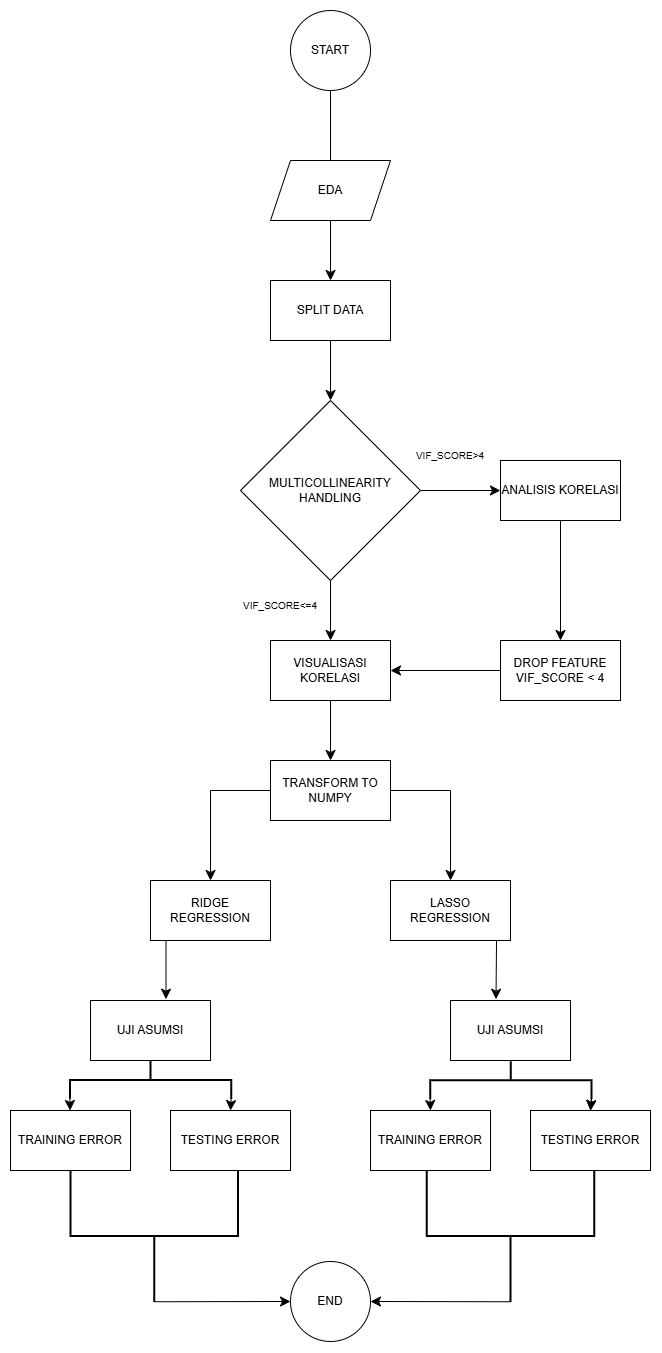

# Load Data

In [196]:
import os

from google.colab import drive
drive.mount('/content/gdrive')
original_data = pd.read_csv("/content/gdrive/My Drive/MRA/Tugas/datania1k.csv")
original_data.info()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1000 non-null   int64  
 1   Gender                1000 non-null   object 
 2   Age                   1000 non-null   int64  
 3   Driving_License       1000 non-null   int64  
 4   Region_Code           1000 non-null   float64
 5   Previously_Insured    1000 non-null   int64  
 6   Vehicle_Age           1000 non-null   object 
 7   Vehicle_Damage        1000 non-null   object 
 8   Annual_Premium        1000 non-null   float64
 9   Policy_Sales_Channel  1000 non-null   float64
 10  Vintage               1000 non-null   int64  
 11  Response              1000 non-null   int64  
dtypes: float64(3), int64(6), object(3)
memory us

In [197]:
original_data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,100000,Male,22,1,8.0,0,< 1 Year,Yes,36513.0,160.0,189,0
1,100001,Male,24,1,36.0,0,< 1 Year,Yes,2630.0,160.0,268,0
2,100002,Female,22,1,15.0,0,< 1 Year,Yes,35832.0,152.0,289,0
3,100003,Male,72,1,28.0,0,> 2 Years,Yes,36685.0,26.0,113,0
4,100004,Male,66,1,28.0,0,> 2 Years,Yes,2630.0,45.0,123,1


In [198]:
le = LabelEncoder()
for col in original_data.select_dtypes(include='object').columns:
    original_data[col] = le.fit_transform(original_data[col].astype(str))
    print("\nTipe data setelah konversi:\n", original_data.dtypes)
print("\n5 data teratas setelah konversi:\n", original_data.head())


Tipe data setelah konversi:
 id                        int64
Gender                    int64
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

Tipe data setelah konversi:
 id                        int64
Gender                    int64
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age               int64
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

Tipe data setelah konversi:
 id                        int64
Gender                    int64
Age                       int64
Driving_License   

# Split Data

In [199]:
# split train test
from sklearn.model_selection import train_test_split

feature = original_data.drop(columns=['id','Response'])
target = original_data[['Response']]

feature_admit_train, feature_admit_test, target_admit_train, target_admit_test = train_test_split(feature, target, test_size=0.20, random_state=16)

# Multicollinearity Handling

In [200]:
# calculate vif score for each column in feature_admit_train
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

X = add_constant(feature_admit_train)

vif_df = (pd.DataFrame(
            [vif(X.values, i) for i in range(len(X.columns))]
            ,index=X.columns)
            .reset_index())

vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,Gender,1.047925
2,Age,1.831902
3,Driving_License,1.017932
4,Region_Code,1.010962
5,Previously_Insured,3.365491
6,Vehicle_Age,1.440258
7,Vehicle_Damage,3.352005
8,Annual_Premium,1.070719
9,Policy_Sales_Channel,1.494597
10,Vintage,1.012025


# Heatmap

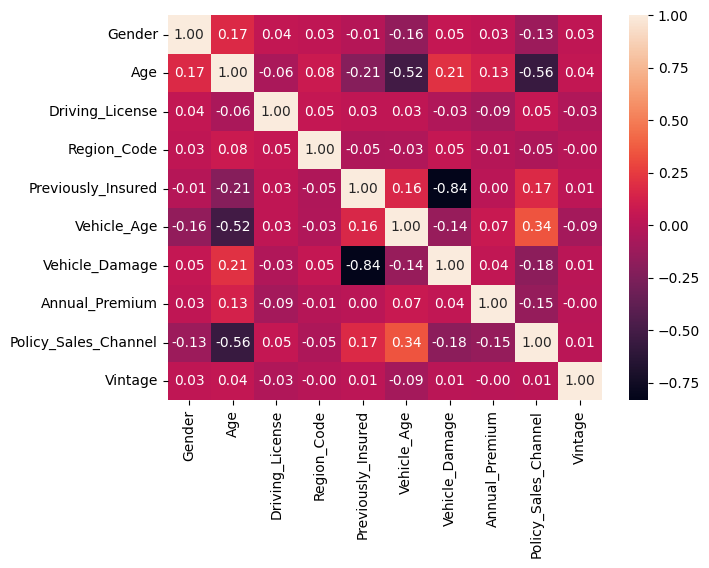

In [201]:
import matplotlib.pyplot as plt
import seaborn as sns
admit_train = pd.concat([feature_admit_train, target_admit_train], axis=1)
# Exclude non-numeric columns before calculating correlation
corr = feature_admit_train.select_dtypes(include=np.number).corr()

plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

# Transform to Numpy

In [202]:
# transform ke numpy array
# train the model
X_admit_train = feature_admit_train.select_dtypes(include=np.number).to_numpy()
y_admit_train = target_admit_train.to_numpy().ravel()

# Ridge Regression

In [203]:
from sklearn.linear_model import Ridge

# define the model
ridge_reg = Ridge(alpha=10,
                  random_state=42)

# train model
ridge_reg.fit(X_admit_train, y_admit_train)

Ridge(alpha=10, random_state=42)

In [204]:
data = pd.get_dummies(feature_admit_train)
model = ridge_reg

coef_df = pd.DataFrame({
    'feature':['intercept'] + data.columns.tolist(),
    'coefficient':[model.intercept_] + list(model.coef_)
})

coef_df

,feature,coefficient
0,intercept,1.144124e-01
1,Gender,1.612793e-02
2,Age,-1.717642e-04
3,Driving_License,2.715447e-02
4,Region_Code,-1.245845e-03
5,Previously_Insured,-6.476105e-02
6,Vehicle_Age,-2.148503e-02
7,Vehicle_Damage,1.569978e-01
8,Annual_Premium,3.591027e-07
9,Policy_Sales_Channel,-4.439925e-04


𝒚 = 1.14 + 1.61 Gender - ...

# Uji Normalitas Residual

In [220]:
y_pred_train_ridge = model.predict(X_admit_train)
residuals = y_admit_train - y_pred_train_ridge

# --- Melakukan Uji Kolmogorov-Smirnov ---
print("Melakukan Uji Normalitas Kolmogorov-Smirnov:")
ks_statistic, p_value = kstest(residuals, 'norm', args=(residuals.mean(), residuals.std()))

# Tampilkan hasilnya
print(f"Statistik Uji Kolmogorov-Smirnov: {ks_statistic:.4f}")
print(f"Nilai p: {p_value:.4f}")

# --- Langkah 4: Interpretasi Hasil ---
alpha = 0.05
print("\nInterpretasi Hasil:")
if p_value > alpha:
    print(f"Nilai p ({p_value:.4f}) > alpha ({alpha})")
    print("Kesimpulan: Residual berdistribusi normal.")
else:
    print(f"Nilai p ({p_value:.4f}) <= alpha ({alpha})")
    print("Kesimpulan: Residual tidak berdistribusi normal.")

Melakukan Uji Normalitas Kolmogorov-Smirnov:
Statistik Uji Kolmogorov-Smirnov: 0.5124
Nilai p: 0.0000

Interpretasi Hasil:
Nilai p (0.0000) <= alpha (0.05)
Kesimpulan: Residual tidak berdistribusi normal.


# Uji Homogenitas

In [221]:

# --- Ekstraksi nilai absolut residual ---
# Ambil residual dari model OLS awal. Residuals sudah dihitung di sel sebelumnya (C9tMojX7KcXq)
# residuals = model.resid # Baris ini menyebabkan AttributeError
residuals_abs = np.abs(residuals)

# --- Regresi nilai absolut residual pada variabel independen ---
# regresikan residuals_abs pada X (variabel independen dari model awal)
print("\n-----------------------------------------------------")
print("Melakukan Uji Glejser: Regresi |Residuals| pada X")
glejser_model = sm.OLS(residuals_abs, X).fit()

# Tampilkan ringkasan hasil regresi Glejser
print(glejser_model.summary())

# --- Interpretasi Hasil Uji Glejser ---
# Periksa nilai p (P>|t|) dari setiap variabel independen
print("\n-----------------------------------------------------")
print("Interpretasi Hasil Uji Glejser:")
alpha = 0.05
print(f"Tingkat Signifikansi (alpha) = {alpha}")

# Cek p-value untuk setiap variabel independen
for i in range(len(glejser_model.pvalues)):
    var_name = glejser_model.params.index[i]
    # Menggunakan .iloc untuk mengakses berdasarkan posisi guna menghindari FutureWarning
    p_value = glejser_model.pvalues.iloc[i]
    if p_value < alpha:
        print(f"Variabel {var_name}: p-value ({p_value:.4f}) < {alpha}. Signifikan.")
        print("Kesimpulan: Ada indikasi heteroskedastisitas.")
    else:
        print(f"Variabel {var_name}: p-value ({p_value:.4f}) >= {alpha}. Tidak signifikan.")
        print("Kesimpulan: Tidak ada indikasi heteroskedastisitas.")

# Kesimpulan akhir
if any(glejser_model.pvalues[1:] < alpha):
    print("\nKesimpulan Akhir: Ada heteroskedastisitas karena setidaknya satu variabel independen signifikan.")
else:
    print("\nKesimpulan Akhir: Tidak ada heteroskedastisitas karena semua variabel independen tidak signifikan.")


-----------------------------------------------------
Melakukan Uji Glejser: Regresi |Residuals| pada X
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     12.66
Date:                Wed, 12 Nov 2025   Prob (F-statistic):           1.27e-20
Time:                        13:59:17   Log-Likelihood:                 41.636
No. Observations:                 800   AIC:                            -61.27
Df Residuals:                     789   BIC:                            -9.742
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------

# Autokorelasi

In [222]:
# --- Melakukan Uji Durbin-Watson ---
print("\n-----------------------------------------------------")
print("Melakukan Uji Autokorelasi Durbin-Watson")
# Residuals sudah dihitung di sel C9tMojX7KcXq sebagai `y_admit_train - y_pred_train_ridge`
dw_statistic = durbin_watson(residuals)

# Tampilkan hasilnya
print(f"Nilai Statistik Durbin-Watson: {dw_statistic:.4f}")

# --- Langkah 3: Interpretasi Hasil ---
print("\nInterpretasi Hasil:")
print("Aturan untuk nilai Durbin-Watson (DW):")
print("- Jika DW mendekati 2: Tidak ada autokorelasi.")
print("- Jika DW mendekati 0: Autokorelasi positif.")
print("- Jika DW mendekati 4: Autokorelasi negatif.")

# Interpretasi berdasarkan nilai statistik
if dw_statistic < 1.5 or dw_statistic > 2.5:
    print("\nKesimpulan: Ada indikasi autokorelasi pada residual")
elif 1.5 <= dw_statistic <= 2.5:
    print("\nKesimpulan: Tidak ada indikasi autokorelasi")


-----------------------------------------------------
Melakukan Uji Autokorelasi Durbin-Watson
Nilai Statistik Durbin-Watson: 2.0678

Interpretasi Hasil:
Aturan untuk nilai Durbin-Watson (DW):
- Jika DW mendekati 2: Tidak ada autokorelasi.
- Jika DW mendekati 0: Autokorelasi positif.
- Jika DW mendekati 4: Autokorelasi negatif.

Kesimpulan: Tidak ada indikasi autokorelasi


In [205]:
ridge_reg_pointzeroone = Ridge(alpha=0.01, random_state=42)
ridge_reg_pointone = Ridge(alpha=0.1, random_state=42)
ridge_reg_one = Ridge(alpha=1, random_state=42)
ridge_reg_ten = Ridge(alpha=10, random_state=42)
ridge_reg_hundred = Ridge(alpha=100, random_state=42)

# fit the model (training)
ridge_reg_pointzeroone.fit(X_admit_train, y_admit_train)
ridge_reg_pointone.fit(X_admit_train, y_admit_train)
ridge_reg_one.fit(X_admit_train, y_admit_train)
ridge_reg_ten.fit(X_admit_train, y_admit_train)
ridge_reg_hundred.fit(X_admit_train, y_admit_train)

Ridge(alpha=100, random_state=42)

In [206]:
from sklearn.metrics import mean_squared_error

# Apply one-hot encoding to validation features and align columns with training features
X_admit_validation =  pd.get_dummies(feature_admit_train)
X_admit_train_encoded_cols =  pd.get_dummies(feature_admit_train).columns
X_admit_validation = X_admit_validation.reindex(columns=X_admit_train_encoded_cols, fill_value=0).to_numpy()

y_admit_validation = target_admit_train.to_numpy().ravel()

alphas = [0.01, 0.1, 1., 10, 100]
models = [ridge_reg_pointzeroone,
          ridge_reg_pointone,
          ridge_reg_one,
          ridge_reg_ten,
          ridge_reg_hundred]

for model, alpha in zip(models, alphas):
    y_predict_validation = model.predict(X_admit_validation)
    rmse = np.sqrt(mean_squared_error(y_admit_validation,y_predict_validation))
    print(f'RMSE of Ridge regression model with alpha = {alpha} is {rmse}')

RMSE of Ridge regression model with alpha = 0.01 is 0.3045591041188241
RMSE of Ridge regression model with alpha = 0.1 is 0.3045607012898908
RMSE of Ridge regression model with alpha = 1.0 is 0.3046076206535305
RMSE of Ridge regression model with alpha = 10 is 0.3047565775605693
RMSE of Ridge regression model with alpha = 100 is 0.30597748732717833


In [207]:
ridge_best = ridge_reg_pointzeroone

# Get feature names from the one-hot encoded training data
encoded_feature_names = pd.get_dummies(feature_admit_train).columns.tolist()

coef_df = pd.DataFrame({
    'feature':['intercept'] + encoded_feature_names,
    'coefficient':[ridge_best.intercept_] + list(ridge_best.coef_)
})

coef_df

,feature,coefficient
0,intercept,-1.734820e-01
1,Gender,1.537186e-02
2,Age,-1.860206e-04
3,Driving_License,3.024855e-01
4,Region_Code,-1.295939e-03
5,Previously_Insured,-5.397052e-02
6,Vehicle_Age,-2.268875e-02
7,Vehicle_Damage,1.745058e-01
8,Annual_Premium,3.965981e-07
9,Policy_Sales_Channel,-4.386532e-04


# Lasso Regression

In [208]:
from sklearn.linear_model import Lasso

# define the model
lasso_reg = Lasso(alpha=10,
                  random_state=42)

# train
lasso_reg.fit(X_admit_train, y_admit_train)

Lasso(alpha=10, random_state=42)

In [209]:
data = pd.get_dummies(feature_admit_train)
model = lasso_reg

coef_df = pd.DataFrame({
    'feature':['intercept'] + data.columns.tolist(),
    'coefficient':[model.intercept_] + list(model.coef_)
})

coef_df

,feature,coefficient
0,intercept,1.026014e-01
1,Gender,0.000000e+00
2,Age,0.000000e+00
3,Driving_License,0.000000e+00
4,Region_Code,-0.000000e+00
5,Previously_Insured,-0.000000e+00
6,Vehicle_Age,-0.000000e+00
7,Vehicle_Damage,0.000000e+00
8,Annual_Premium,6.587458e-07
9,Policy_Sales_Channel,-0.000000e+00


# Uji Normalitas Residual

In [225]:
y_pred_train_lasso = model.predict(X_admit_train)
residuals = y_admit_train - y_pred_train_lasso

# --- Melakukan Uji Kolmogorov-Smirnov ---
print("Melakukan Uji Normalitas Kolmogorov-Smirnov:")
ks_statistic, p_value = kstest(residuals, 'norm', args=(residuals.mean(), residuals.std()))

# Tampilkan hasilnya
print(f"Statistik Uji Kolmogorov-Smirnov: {ks_statistic:.4f}")
print(f"Nilai p: {p_value:.4f}")

# --- Langkah 4: Interpretasi Hasil ---
alpha = 0.05
print("\nInterpretasi Hasil:")
if p_value > alpha:
    print(f"Nilai p ({p_value:.4f}) > alpha ({alpha})")
    print("Kesimpulan: Residual berdistribusi normal.")
else:
    print(f"Nilai p ({p_value:.4f}) <= alpha ({alpha})")
    print("Kesimpulan: Residual tidak berdistribusi normal.")

Melakukan Uji Normalitas Kolmogorov-Smirnov:
Statistik Uji Kolmogorov-Smirnov: 0.5124
Nilai p: 0.0000

Interpretasi Hasil:
Nilai p (0.0000) <= alpha (0.05)
Kesimpulan: Residual tidak berdistribusi normal.


# Uji Homogenitas

In [226]:
# --- Ekstraksi nilai absolut residual ---
# Ambil residual dari model OLS awal. Residuals sudah dihitung di sel sebelumnya (C9tMojX7KcXq)
# residuals = model.resid # Baris ini menyebabkan AttributeError
residuals_abs = np.abs(residuals)

# --- Regresi nilai absolut residual pada variabel independen ---
# regresikan residuals_abs pada X (variabel independen dari model awal)
print("\n-----------------------------------------------------")
print("Melakukan Uji Glejser: Regresi |Residuals| pada X")
glejser_model = sm.OLS(residuals_abs, X).fit()

# Tampilkan ringkasan hasil regresi Glejser
print(glejser_model.summary())

# --- Interpretasi Hasil Uji Glejser ---
# Periksa nilai p (P>|t|) dari setiap variabel independen
print("\n-----------------------------------------------------")
print("Interpretasi Hasil Uji Glejser:")
alpha = 0.05
print(f"Tingkat Signifikansi (alpha) = {alpha}")

# Cek p-value untuk setiap variabel independen
for i in range(len(glejser_model.pvalues)):
    var_name = glejser_model.params.index[i]
    # Menggunakan .iloc untuk mengakses berdasarkan posisi guna menghindari FutureWarning
    p_value = glejser_model.pvalues.iloc[i]
    if p_value < alpha:
        print(f"Variabel {var_name}: p-value ({p_value:.4f}) < {alpha}. Signifikan.")
        print("Kesimpulan: Ada indikasi heteroskedastisitas.")
    else:
        print(f"Variabel {var_name}: p-value ({p_value:.4f}) >= {alpha}. Tidak signifikan.")
        print("Kesimpulan: Tidak ada indikasi heteroskedastisitas.")

# Kesimpulan akhir
if any(glejser_model.pvalues[1:] < alpha):
    print("\nKesimpulan Akhir: Ada heteroskedastisitas karena setidaknya satu variabel independen signifikan.")
else:
    print("\nKesimpulan Akhir: Tidak ada heteroskedastisitas karena semua variabel independen tidak signifikan.")


-----------------------------------------------------
Melakukan Uji Glejser: Regresi |Residuals| pada X
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     12.66
Date:                Wed, 12 Nov 2025   Prob (F-statistic):           1.27e-20
Time:                        14:01:57   Log-Likelihood:                 41.636
No. Observations:                 800   AIC:                            -61.27
Df Residuals:                     789   BIC:                            -9.742
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------

# Uji Autokorelasi

In [227]:
# --- Melakukan Uji Durbin-Watson ---
print("\n-----------------------------------------------------")
print("Melakukan Uji Autokorelasi Durbin-Watson")
# Residuals sudah dihitung di sel C9tMojX7KcXq sebagai `y_admit_train - y_pred_train_ridge`
dw_statistic = durbin_watson(residuals)

# Tampilkan hasilnya
print(f"Nilai Statistik Durbin-Watson: {dw_statistic:.4f}")

# --- Langkah 3: Interpretasi Hasil ---
print("\nInterpretasi Hasil:")
print("Aturan untuk nilai Durbin-Watson (DW):")
print("- Jika DW mendekati 2: Tidak ada autokorelasi.")
print("- Jika DW mendekati 0: Autokorelasi positif.")
print("- Jika DW mendekati 4: Autokorelasi negatif.")

# Interpretasi berdasarkan nilai statistik
if dw_statistic < 1.5 or dw_statistic > 2.5:
    print("\nKesimpulan: Ada indikasi autokorelasi pada residual")
elif 1.5 <= dw_statistic <= 2.5:
    print("\nKesimpulan: Tidak ada indikasi autokorelasi")


-----------------------------------------------------
Melakukan Uji Autokorelasi Durbin-Watson
Nilai Statistik Durbin-Watson: 2.0678

Interpretasi Hasil:
Aturan untuk nilai Durbin-Watson (DW):
- Jika DW mendekati 2: Tidak ada autokorelasi.
- Jika DW mendekati 0: Autokorelasi positif.
- Jika DW mendekati 4: Autokorelasi negatif.

Kesimpulan: Tidak ada indikasi autokorelasi


In [210]:
from sklearn.linear_model import Lasso

# define the model
# multiple models with different alphas (lambda)
lasso_reg_pointzeroone = Lasso(alpha=0.01, random_state=42)
lasso_reg_pointone = Lasso(alpha=0.1, random_state=42)
lasso_reg_one = Lasso(alpha=1, random_state=42)
lasso_reg_ten = Lasso(alpha=10, random_state=42)
lasso_reg_hundred = Lasso(alpha=100, random_state=42)

# fit the model (training)
lasso_reg_pointzeroone.fit(X_admit_train, y_admit_train)
lasso_reg_pointone.fit(X_admit_train, y_admit_train)
lasso_reg_one.fit(X_admit_train, y_admit_train)
lasso_reg_ten.fit(X_admit_train, y_admit_train)
lasso_reg_hundred.fit(X_admit_train, y_admit_train)

Lasso(alpha=100, random_state=42)

In [211]:
from sklearn.metrics import mean_squared_error

# Apply one-hot encoding to validation features and align columns with training features
X_admit_validation =  pd.get_dummies(feature_admit_train)
X_admit_train_encoded_cols =  pd.get_dummies(feature_admit_train).columns
X_admit_validation = X_admit_validation.reindex(columns=X_admit_train_encoded_cols, fill_value=0).to_numpy()

y_admit_validation = target_admit_train.to_numpy().ravel()

alphas = [0.01, 0.1, 1., 10, 100]
models = [lasso_reg_pointzeroone,
          lasso_reg_pointone,
          lasso_reg_one,
          lasso_reg_ten,
          lasso_reg_hundred]

for model, alpha in zip(models, alphas):
    y_predict_validation = model.predict(X_admit_validation)
    rmse = np.sqrt(mean_squared_error(y_admit_validation,y_predict_validation))
    print(f'RMSE of Ridge regression model with alpha = {alpha} is {rmse}')

RMSE of Ridge regression model with alpha = 0.01 is 0.30583890414237264
RMSE of Ridge regression model with alpha = 0.1 is 0.3236905696795712
RMSE of Ridge regression model with alpha = 1.0 is 0.3247494148212996
RMSE of Ridge regression model with alpha = 10 is 0.32765386847237565
RMSE of Ridge regression model with alpha = 100 is 0.3277069400126184


In [212]:
lasso_best = lasso_reg_pointzeroone

# Get feature names from the one-hot encoded training data
encoded_feature_names = pd.get_dummies(feature_admit_train).columns.tolist()

coef_df = pd.DataFrame({
    'feature':['intercept'] + encoded_feature_names,
    'coefficient':[lasso_best.intercept_] + list(lasso_best.coef_)
})

coef_df

,feature,coefficient
0,intercept,1.096180e-01
1,Gender,0.000000e+00
2,Age,4.391622e-04
3,Driving_License,0.000000e+00
4,Region_Code,-1.133033e-03
5,Previously_Insured,-2.911806e-02
6,Vehicle_Age,-0.000000e+00
7,Vehicle_Damage,1.532946e-01
8,Annual_Premium,2.116705e-07
9,Policy_Sales_Channel,-5.053425e-04


# Training Error dan Testing Error

# Ridge Error

In [213]:
y_predict_train = ridge_best.predict(X_admit_train)

In [214]:
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for training data is {}'.format(root_mean_squared_error(y_admit_train, y_predict_train)))
print('MAE for training data is {}'.format(mean_absolute_error(y_admit_train, y_predict_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_admit_train, y_predict_train)))

RMSE for training data is 0.3045591041188241
MAE for training data is 0.1998260390960141
MAPE for training data is 482192400196658.75


In [215]:
# Apply one-hot encoding to test features and align columns with training features
X_admit_test_processed = pd.get_dummies(feature_admit_test) # Correctly use feature_admit_test
X_admit_train_encoded_cols = pd.get_dummies(feature_admit_train).columns
X_admit_test = X_admit_test_processed.reindex(columns=X_admit_train_encoded_cols, fill_value=0).to_numpy()

y_predict_test = ridge_best.predict(X_admit_test)

# ground truth target
y_admit_test = target_admit_test.to_numpy().ravel()

In [216]:
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for testing data is {}'.format(root_mean_squared_error(y_admit_test, y_predict_test)))
print('MAE for testing data is {}'.format(mean_absolute_error(y_admit_test, y_predict_test)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_admit_test, y_predict_test)))

RMSE for testing data is 0.3036042588133131
MAE for testing data is 0.20293860668541852
MAPE for testing data is 495242785706983.4


# Lasso Error

In [217]:
# Use the best Lasso model (lasso_best) to predict on the training data
y_predict_train = lasso_best.predict(X_admit_train)

In [218]:
# Apply one-hot encoding to test features and align columns with training features
X_admit_test_processed = pd.get_dummies(feature_admit_test) # Correctly use feature_admit_test
X_admit_train_encoded_cols = pd.get_dummies(feature_admit_train).columns
X_admit_test = X_admit_test_processed.reindex(columns=X_admit_train_encoded_cols, fill_value=0).to_numpy()

y_predict_test = lasso_best.predict(X_admit_test)

# ground truth target
y_admit_test = target_admit_test.to_numpy().ravel()

In [219]:
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for training data is {}'.format(root_mean_squared_error(y_admit_train, y_predict_train)))
print('MAE for training data is {}'.format(mean_absolute_error(y_admit_train, y_predict_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_admit_train, y_predict_train)))

RMSE for training data is 0.30583890414237264
MAE for training data is 0.1948108892454383
MAPE for training data is 447784643630004.94
